### model brand

In [1]:
import pandas as pd
import re
import numpy as np

In [2]:
def load_df_products(name):
    return pd.read_csv(f'../data/processed/data_beer_{name}.csv')

In [3]:
data_beer = load_df_products('total')

In [4]:
data_beer.head()

,price,price_liter,title,promotion,brand,container,volumen_unid,quantity_pack,image_url,supermarket,promotion_check,id,specials
0,8.99,1.51,Cerveza Heineken Lager pack de 18 latas de 33 cl.,No promotion,heineken,lata,33 cl,18,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,no,0,others
1,14.28,1.55,Cerveza Cruzcampo Pilsen pack de 28 latas de 3...,2ª al -50%,cruzcampo,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,yes,1,others
2,5.15,1.56,Cerveza El Aguila pack de 10 latas de 33 cl.,No promotion,el águila,lata,33 cl,10,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,no,2,others
3,0.25,0.76,Cerveza Carrefour Holandesa lata 33 cl.,3x2,carrefour,lata,33 cl,1,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,yes,3,others
4,10.64,1.15,Cerveza Mahou Clásica pack de 28 latas de 33 cl.,No promotion,mahou clasica,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,no,4,others


In [21]:
def change_volume(text):
    text = text.lower()
    text = text.rstrip()
    text = text.lstrip()
    number_cl = re.findall('[a-z]+',text)
    if len(number_cl)==0:
        take_number = re.findall('[0-9]+', text)
        return take_number[0] + ' cl'
    if text == '33cl':
        return '33 cl'
    elif text == '50cl':
        return '50 cl'
    number_c = re.findall('l',text)
    if len(number_c) == 0:
        return text + 'l'
    
    return text

In [22]:
data_beer['volumen_unid'].apply(change_volume).value_counts()

33 cl       911
25 cl       233
50 cl       184
1 l          43
75 cl        26
35,5 cl      17
44 cl        11
35,50 cl      9
20 cl         8
21 cl         7
30 cl         5
37,5 cl       5
37 cl         4
5 l           3
66 cl         3
70 cl         3
33,5 cl       3
34 cl         2
45 cl         2
2 l           2
35.5 cl       2
55 cl         1
250 ml        1
20,7 cl       1
28,5 cl       1
33,50 cl      1
60 cl         1
40 cl         1
330 cl        1
355 ml        1
27,5 cl       1
50 ml         1
Name: volumen_unid, dtype: int64

In [22]:
def promotion_list(text):
    if text != 'No promotion':
        return 'yes'
    else:
        return 'no'
    
data_beer['promotion'].apply(promotion_list)

0        no
1       yes
2        no
3       yes
4        no
       ... 
1585     no
1586     no
1587     no
1588     no
1589     no
Name: promotion, Length: 1590, dtype: object

In [27]:
data_beer.sort_values('price_liter', inplace=True, ignore_index=True)
data_beer['price_liter'][0]

0.19

In [9]:
data_beer[data_beer['promotion'] != 'No promotion']['promotion'].count()

600

In [58]:
lager ='''ramblers|amstel|dia'''

Pilsen='''mahou|heineken'''

In [26]:
def artesana(text):
    artesana = re.findall('artesana',text.lower())
    if len(artesana)!=0:
        return 'Artesana'

data_beer['Artesana']=data_beer['title'].apply(artesana)

data_beer[data_beer['Artesana']=='Artesana']['supermarket'].value_counts()

El Corte Ingles    58
Carrefour          26
Alcampo            19
Eroski              5
Name: supermarket, dtype: int64

In [27]:
def ipa(text):
    ipa_beer = re.findall('ipa',text.lower())
    if len(ipa_beer)!=0:
        return 'IPA'

data_beer['IPA']=data_beer['title'].apply(ipa)

data_beer[data_beer['IPA']=='IPA']['supermarket'].value_counts()

El Corte Ingles    22
Alcampo            20
Carrefour          17
Eroski             12
Dia                 1
Name: supermarket, dtype: int64

In [28]:
def oscura(text):
    oscura = re.findall('oscura|negra|porter',text.lower())
    if len(oscura)!=0:
        return 'negra'

data_beer['negra']=data_beer['title'].apply(oscura)

data_beer[data_beer['negra']=='negra']['supermarket'].value_counts()

El Corte Ingles    30
Alcampo            16
Carrefour          15
Eroski              8
Dia                 1
Name: supermarket, dtype: int64

In [29]:
def sin_alcohol(text):
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',text.lower())
    if len(sin_alcohol)!=0:
        return 'sin alcohol'

data_beer['sin_alcohol']=data_beer['title'].apply(sin_alcohol)

data_beer[data_beer['sin_alcohol']=='sin alcohol']['supermarket'].value_counts()

Alcampo            59
Carrefour          48
El Corte Ingles    48
Eroski             35
Dia                12
Name: supermarket, dtype: int64

In [44]:
def radler(text):
    radler = re.findall('radler', text.lower())
    if len(radler) != 0:
        return 'radler'

data_beer['radler']=data_beer['title'].apply(radler)

data_beer[data_beer['radler']=='radler']['supermarket'].value_counts()


Alcampo            19
Carrefour          18
Eroski             13
El Corte Ingles    12
Dia                 5
Name: supermarket, dtype: int64

In [31]:
def eco(text):
    eco = re.findall('ecológica|ecologica|eco', text.lower())
    if len(eco) != 0:
        return 'ecologica'

data_beer['eco']=data_beer['title'].apply(eco)

data_beer[data_beer['eco']=='ecologica']['supermarket'].value_counts()

Carrefour          8
Alcampo            2
El Corte Ingles    1
Name: supermarket, dtype: int64

In [32]:
def sin_gluten(text):
    sin_gluten = re.findall('sin gluten', text.lower())
    if len(sin_gluten) != 0:
        return 'sin gluten'

data_beer['sin_gluten']=data_beer['title'].apply(sin_gluten)

data_beer[data_beer['sin_gluten']=='sin gluten']['supermarket'].value_counts()


Carrefour          11
El Corte Ingles    10
Alcampo             9
Eroski              5
Dia                 1
Name: supermarket, dtype: int64

In [45]:
def beer_specials(text):
    add = ''
    art = artesana(text)
    if art:
        add+=art +' '
    ipaa = ipa(text)
    if ipaa:
        add+=ipaa +' '
    osc = oscura(text)
    if osc:
        add+=osc +' '
    sia = sin_alcohol(text)
    if sia:
        add+=sia +' '
    rad = radler(text)
    if rad:
        add+=rad +' '
    sig = sin_gluten(text)
    if sig:
        add+=sig +' '
    ecoo = eco(text)
    if ecoo:
        add+=ecoo +' '
    if len(add)>1:
        return add
    else:
        return 'others'


In [46]:
data_beer['specials']=data_beer['title'].apply(beer_specials)

data_beer['specials'].value_counts()


others                               1068
sin alcohol                           172
Artesana                               73
negra                                  56
IPA                                    50
radler                                 44
sin gluten                             30
sin alcohol radler                     22
Artesana IPA                           22
Artesana negra                         10
ecologica                               6
negra sin alcohol                       4
sin alcohol sin gluten                  3
Artesana ecologica                      2
sin alcohol sin gluten ecologica        1
sin gluten ecologica                    1
radler ecologica                        1
Artesana sin gluten                     1
Name: specials, dtype: int64

In [47]:
def change_brand(brand_raw):
    names_brands = '''ramblers|amstel|mahou|dia|heineken|san miguel|estrella galicia|voll-damm|1906|budweiser|
    |cruzcampo|buckler|dia shandy|desperado|grimbergen|franziskaner|paulaner|corona|guinness|el aguila|
    |ambar|alhambra|coronita|leffe|kronenbourg|carlsberg|la salve|warsteiner|mexicana|pacífico|guiness|
    |founders|spatem|beck|cubanisto|aurum|keler|woll-damm|aurum|ambar|free damm|ladrón de manzanas|
    |brewdog|ipa lagunitas|inedit|daura|oro|estrella damm|damm|complot|corgon gard|judas|olañeta|
    |grevensteiner|inedit|chimay|house 13|lorea ipa boga|trappe|mort subite|kirin|urquell|cruz campo|
    |malquerida|moretti|clausthaler|affligem|stella artoi|sol|quilmes|daura marzen|turia|boga|
    |schöfferhofer|grolsch|la goudale|atkien dunkel|chérie|belzebuth|la virgen|lowenbrau|bulmers|jai alai|
    |strongbow|cruz del sur|voll damm|estrella levante|xibeca|victoria|estrella del sur|aliada|moritz|
    |brabante|superbock|kirin ichiban|staropramen|waterloo|weltenburger|schwaben|dab|praga|abbot|
    |lowenbräu|spaten|hofbräu|dos equis|birra moretti|karmeliet|kwak|gordon|martin's|delirium tremens|veltins|
    |pacifico|triple secret des moine|la bière du demon|baltika|molino viejo|cusqueña|cobra|zywiec|barista|
    |bischofshof|hoegaarden|schofferhofer|erdinger|konig ludwig|rosita|burro de sancho|
    |monkey|arriaca|ladron de manzanas|kopparberg|la sagra|sierra nevada|montseny|maisel & friends|
    |tyris|rabiosa|jaira|forastera|cibeles|mulhacen|gredos|ballut|madri chulapo|gastheiz|quijota|
    |marijuana|moli balear|dolina|icue|bizantina|bavaria|newcastle|timmermans|modelo|heifer|holbrand|
    |rubai|el águila|estrella de galicia|chouffe|peroni|miller|goya|super bock|sam miguel|karamalz|
    |skol|budejovicky|wersteiner|duvel|schneider weisse|john smith's|blue moon|rochefort-8|salitos|
    |old empire|köning ludwing weissbier|könig ludwig weissbier|blanche de charleroi|ruddles|
    |madrí chulapo|abbaye d'aulne|g de goudale|cuzqueña|london pride|wychwood hobgoblin|sureña|
    |innis&gunn|intense gold|faxe|bitburger|lindemans|maisel&friends|pearl jet|the one|original intense|
    |licher|tennent's|tedeum|enigma|mulhacén|gervensteiner|abbaye du lys|greventeiner|liefmans|rubia 4|
    |san sebastian|maisel|carrefour|koenigsbier|polar|coors|kadabra|brooklyn|alsfelder|madriz|presidente|
    |fentiman's de jengibre|lammsbräu|riedenburger|benediktinerabtei|iron maiden|old speckled hen|
    |ordio minero|rubia dab|corte ingles|thatchers gold'''
  
    brand = re.findall(names_brands,brand_raw.lower())
    if len(brand)>1:
        for name in brand:
            if len(name)>3:
                return name
    else:
        return brand[0]

Welcome beer lovers! \U0001f37a  
In this dashboard you will be able to discover the price of your favorite beer in the following supermarkets:
- Carrefour
- Alcampo
- El Corte ingles
- Dia
- Eroski 

In [48]:
data_beer['title'].apply(change_brand)

0        heineken
1       cruzcampo
2       el aguila
3       carrefour
4           mahou
          ...    
1561    cruzcampo
1562    la virgen
1563        ambar
1564    lowenbrau
1565     brooklyn
Name: title, Length: 1566, dtype: object

In [7]:
data_beer['brand'] = data_beer['title'].apply(change_brand)

data_beer.head()

,price,price_liter,title,promotion,brand,container,volumen_unid,quantity_pack,image_url,supermarket,id
0,11.21,1.89,Cerveza Heineken Lager pack de 18 latas de 33 cl.,No promotion,heineken,lata,33 cl,18,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,0
1,14.80,1.60,Cerveza Cruzcampo Pilsen pack de 28 latas de 3...,No promotion,cruzcampo,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,1
2,5.15,1.56,Cerveza El Aguila pack de 10 latas de 33 cl.,No promotion,el aguila,lata,33 cl,10,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,2
3,0.25,0.76,Cerveza Carrefour Holandesa lata 33 cl.,No promotion,carrefour,lata,33 cl,1,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,3
4,14.15,1.53,Cerveza Mahou Clásica pack de 28 latas de 33 cl.,No promotion,mahou,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,4


In [8]:
def mahou_types(title):
    title = title.lower()
    
    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'mahou sin gluten'
    
    radler = re.findall('radler',title)
    if len(radler)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'mahou radler sin alcohol 0,0%'
        else:
            return 'mahou radler'
    
    clasica = re.findall('[clasicá]{7,}',title)
    if len(clasica)!=0:
        return 'mahou clasica'
    
    mixta = re.findall('mixta|shandy', title)
    if len(mixta)!=0:
        return 'mahou mixta'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'mahou sin alcohol 0,0%'
    
    ipa = re.findall('ipa',title)
    if len(ipa)!=0:
        return 'mahou ipa'
    
    maestra = re.findall('maestra',title)
    if len(maestra)!=0:
        return 'mahou maestra'
    
    barrica = re.findall('barrica',title)
    if len(barrica)!=0:
        return 'mahou barrica'
    
    casimiro = re.findall('casimiro',title)
    if len(casimiro)!=0:
        return 'mahou casimiro'
    
    roja = re.findall('mahou',title)
    if len(roja)!=0:
        return 'mahou 5 estrellas'
    

In [9]:
def san_miguel_types(title):
    title = title.lower()

    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'san miguel sin gluten'
    
    radler = re.findall('radler',title)
    if len(radler)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'san miguel radler sin alcohol 0,0%'
        else:
            return 'san miguel radler'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'san miguel sin alcohol 0,0%'

    ipa = re.findall('ipa',title)
    if len(ipa)!=0:
        return 'san miguel ipa'

    magna = re.findall('magna',title)
    if len(magna)!=0:
        return 'san miguel magna'

    selecta = re.findall('selecta',title)
    if len(selecta)!=0:
        return 'san miguel selecta'

    manila = re.findall('manila',title)
    if len(manila)!=0:
        return 'san miguel manila'

    eco = re.findall('ecológica',title)
    if len(eco)!=0:
        return 'san miguel ecologica'

    premium = re.findall('1516',title)
    if len(premium)!=0:
        return 'san miguel 1516'

    fresca = re.findall('fresca',title)
    if len(fresca)!=0:
        return 'san miguel fresca'

    return 'san miguel'
    

In [10]:
def amstel_types(title):
    title = title.lower()

    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'amstel sin gluten'
    
    radler = re.findall('radler',title)
    if len(radler)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'amstel radler sin alcohol 0,0%'
        else:
            return 'amstel radler'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'amstel sin alcohol 0,0%'
    
    oro = re.findall('oro',title)
    if len(oro)!=0:
        return 'amstel oro'

    extra = re.findall('extra',title)
    if len(extra)!=0:
        return 'amstel extra'
    
    clasica = re.findall('[clasicá]{7,}',title)
    if len(clasica)!=0:
        return 'amstel clasica'
    
    return 'amstel original'


In [11]:
def cruzacampo_types(title):
    title = title.lower()

    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'cruzcampo sin gluten'
    
    shandy = re.findall('shandy',title)
    if len(shandy)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'cruzcampo shandy sin alcohol 0,0%'
        else:
            return 'cruzcampo shandy'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'cruzcampo sin alcohol 0,0%'
    
    radler = re.findall('radler',title)
    if len(radler)!=0:
        return 'cruzcampo radler'
    
    ipa = re.findall('ipa|andalusian',title)
    if len(ipa)!=0:
        return 'cruzcampo ipa'
    
    reserva = re.findall('gran reserva',title)
    if len(reserva)!=0:
        return 'cruzcampo reserva'

    especial = re.findall('especial',title)
    if len(especial)!=0:
        return 'cruzcampo especial'

    radler = re.findall('radler',title)
    if len(radler)!=0:
        return 'cruzcampo radler'

    cruzial = re.findall('cruzial',title)
    if len(cruzial)!=0:
        return 'cruzcampo cruzial'
    
    return 'cruzcampo'

In [12]:
def ambar_types(title):
    title = title.lower()

    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'ambar sin gluten'
    
    radler = re.findall('radler',title)
    if len(radler)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'ambar radler sin alcohol 0,0%'
        else:
            return 'ambar radler'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'ambar sin alcohol 0,0%'
    
    export = re.findall('export',title)
    if len(export)!=0:
        return 'ambar export'

    ipa = re.findall('ipa|indian',title)
    if len(ipa)!=0:
        return 'ambar ipa'

    number = re.findall('1900',title)
    if len(number)!=0:
        return 'ambar 1900' 
    
    ambiciosa = re.findall('ambiciosa',title)
    if len(ambiciosa)!=0:
        return 'ambar ambiciosa' 

    pedigree = re.findall('pedigree',title)
    if len(pedigree)!=0:
        return 'marston’s pedigree' 
    
    return 'ambar'

In [13]:
def alhambra_types(title):
    title = title.lower()

    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'alhambra sin gluten'
    
    radler = re.findall('radler',title)
    if len(radler)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'alhambra radler sin alcohol 0,0%'
        else:
            return 'alhambra radler'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'alhambra sin alcohol 0,0%'
    
    number = re.findall('1925',title)
    if len(number)!=0:
        return 'alhambra 1925'

    ipa = re.findall('ipa',title)
    if len(ipa)!=0:
        return 'alhambra ipa'
    
    roja = re.findall('roja',title)
    if len(roja)!=0:
        return 'alhambra roja'

    granadino = re.findall('granadino',title)
    if len(granadino)!=0:
        return 'alhambra gran granadino'
    
    baltic = re.findall('baltic',title)
    if len(baltic)!=0:
        return 'alhambra baltic porter'

    envejecida = re.findall('envejecida',title)
    if len(envejecida)!=0:
        return 'alhambra envejecida'
    
    especial = re.findall('especial',title)
    if len(especial)!=0:
        return 'alhambra especial'
    
    return 'alhambra'

In [14]:
def heineken_types(title):
    title = title.lower()
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'heineken sin alcohol 0,0%'
    
    return 'heineken'

In [15]:
def estrella_galicia_types(title):
    title = title.lower()

    sin_gluten = re.findall('sin gluten',title)
    if len(sin_gluten)!=0:
        return 'estrella galicia sin gluten'
    
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'estrella galicia sin alcohol 0,0%'
    
    return 'estrella galicia'

def estrella_1906_types(title):
    title = title.lower()
    
    red = re.findall('red',title)
    if len(red)!=0:
        return 'estrella galicia 1906 red'
    
    return 'estrella galicia 1906'
    
    

In [16]:
def carrefour_types(title):
    title = title.lower()

    radler = re.findall('radler',title)
    if len(radler)!=0:
        sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
        if len(sin_alcohol)!=0:
            return 'carrefour radler sin alcohol 0,0%'
        else:
            return 'carrefour radler'
        
    sin_alcohol = re.findall('[0.,]{3}|sin alcohol',title)
    if len(sin_alcohol)!=0:
        return 'carrefour sin alcohol 0,0%'
    
    shandy = re.findall('shandy',title)
    if len(shandy)!=0:
        return 'carrefour shandy'

    pils = re.findall('pils',title)
    if len(pils)!=0:
        return 'carrefour pils'

    abadia = re.findall('abad',title)
    if len(pils)!=0:
        return 'carrefour abadia'

    negra = re.findall('negra',title)
    if len(negra)!=0:
        return 'carrefour negra'
    
    especial = re.findall('especial',title)
    if len(especial)!=0:
        return 'carrefour especial'

    extra = re.findall('extra',title)
    if len(extra)!=0:
        return 'carrefour extra'
    
    return 'carrefour'


In [17]:
def duplicate_brand_error(info):
    data = info[0]
    title = info[1]
    
    if data == 'guiness':
        return 'guinness'
    elif data == 'voll damm':
        return 'voll-damm'
    elif data == 'schofferhofer':
        return 'schöfferhofer'
    elif data == 'ladron de manzanas':
        return 'ladrón de manzanas'
    elif data == 'el aguila':
        return 'el águila'
    elif data == 'superbock':
        return 'super bock'
    elif data == 'madri chulapo':
        return 'madrí chulapo'
    elif data == ('maisel' or 'maisel&friends'):
        return 'maisel & friends'
    elif data == 'köning ludwing weissbier':
        return 'könig ludwig weissbier'
    #dividimos las grandes marcas por sus tipos(mejorar modelo)
    elif (data == 'sam miguel') or (data == 'san miguel'):
        return san_miguel_types(title)
    elif (data == 'cruz campo') or (data == 'cruzcampo'):
        return cruzacampo_types(title)
    elif (data == 'estrella de galicia') or (data == 'estrella galicia'):
        return estrella_galicia_types(title)
    elif data == '1906':
        return estrella_1906_types(title)    
    elif data == 'mahou':
        return mahou_types(title)
    elif data == 'amstel':
        return amstel_types(title)
    elif data == 'ambar':
        return ambar_types(title)
    elif data == 'alhambra':
        return alhambra_types(title)
    elif data == 'heineken':
        return heineken_types(title)
    elif data == 'carrefour':
        return carrefour_types(title)
    else:
        return data

In [18]:
data_beer['brand'] = data_beer[['brand','title']].apply(duplicate_brand_error, axis=1)

In [19]:
data_beer_clean = data_beer

In [45]:
data_beer_clean.to_csv(f'../data/processed/data_beer_clean.csv', index=False)

In [50]:
data_beer[data_beer['container']=='No specified']['image_url']

KeyError: 0

In [24]:
data_beer['brand'].value_counts()#.index.tolist()
# .index.tolist()

san miguel           38
heineken             38
mahou clasica        37
mahou 5 estrellas    33
estrella galicia     32
                     ..
waterloo              1
rubai                 1
corgon gard           1
jai alai              1
duvel                 1
Name: brand, Length: 275, dtype: int64

In [20]:
brands_model=['heineken', 'san miguel', 'mahou clasica', 'mahou 5 estrellas', 'estrella galicia']

data_beer.brand.isin(brands_model)

0        True
1       False
2       False
3       False
4        True
        ...  
1561    False
1562    False
1563    False
1564    False
1565    False
Name: brand, Length: 1566, dtype: bool

In [21]:
prueba = data_beer[data_beer.brand.isin(brands_model)]
prueba.reset_index(inplace=True)
prueba.head()

,index,price,price_liter,title,promotion,brand,container,volumen_unid,quantity_pack,image_url,supermarket,id
0,0,11.21,1.89,Cerveza Heineken Lager pack de 18 latas de 33 cl.,No promotion,heineken,lata,33 cl,18,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,0
1,4,14.15,1.53,Cerveza Mahou Clásica pack de 28 latas de 33 cl.,No promotion,mahou clasica,lata,33 cl,28,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,4
2,5,11.70,1.95,Cerveza Estrella Galicia especial pack de 24 b...,No promotion,estrella galicia,botella,25 cl,24,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,5
3,6,6.41,1.94,Cerveza Estrella Galicia especial pack de 10 l...,No promotion,estrella galicia,lata,33 cl,10,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,6
4,7,6.72,1.70,Cerveza Mahou Clásica pack de 12 latas de 33 cl.,Feliz Aniversario,mahou clasica,lata,33 cl,12,https://static.carrefour.es/hd_280x_/img_pim_f...,Carrefour,7


In [22]:
prueba['brand'].value_counts()

san miguel           38
heineken             38
mahou clasica        37
mahou 5 estrellas    33
estrella galicia     32
Name: brand, dtype: int64

In [55]:
data_beer_images= pd.DataFrame(columns=['local','brand'])
data_beer_images['brand'] = prueba['brand']

In [56]:
def local_beer(local):
    return f'/home/ivan/Documentos/IRONHACK/Bootcamp/final_project/Birras_Pipol_House/beer_images/validattion/{local}.jpg'

In [57]:
data_beer_images['local'] = prueba['id'].apply(local_beer)

In [58]:
data_beer_images['local'][0]

'/home/ivan/Documentos/IRONHACK/Bootcamp/final_project/Birras_Pipol_House/beer_images/validattion/0.jpg'

In [59]:
data_beer_images['brand'].head()

0            heineken
1       mahou clasica
2    estrella galicia
3    estrella galicia
4       mahou clasica
Name: brand, dtype: object

In [31]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

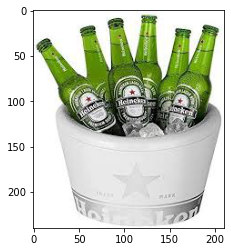

In [34]:
I = Image.open("../beer_images/train/heineken/000210.jpg")
plt.imshow(np.asarray(I))
plt.show()


In [35]:
print(I.size, I.format)

(210, 240) JPEG


In [42]:
from sklearn.model_selection import train_test_split
beer_train_prueba, beer_test = train_test_split(data_beer_images,train_size=0.83)
beer_train = pd.DataFrame(beer_train_prueba, columns=['local','brand']).sample(frac=1.0)

In [43]:
beer_test.head()

,local,brand
129,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,mahou 5 estrellas
165,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,estrella galicia
167,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,heineken
108,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,estrella galicia
153,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,san miguel


In [44]:
beer_train.shape

(147, 2)

In [45]:
beer_test.shape

(31, 2)

In [19]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from sklearn.utils import class_weight
from keras.applications.inception_v3 import preprocess_input

In [51]:
datagen_train=ImageDataGenerator(rescale=1./255.,
                                validation_split=0.1,
                                rotation_range=80,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                preprocessing_function=preprocess_input)

train_generator=datagen_train.flow_from_dataframe(dataframe=beer_train,
                                            x_col="local",
                                            y_col="brand",
                                            subset="training",
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(280,280))

datagen_valid=ImageDataGenerator(rescale=1./255., validation_split=0.1)
valid_generator=datagen_valid.flow_from_dataframe(dataframe=beer_train,
                                            x_col="local",
                                            y_col="brand",
                                            subset="validation",
                                            batch_size=18,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(280,280))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=beer_test,
                                                x_col="local",
                                                y_col=None,
                                                batch_size=18,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(280,280))

Found 144 validated image filenames belonging to 5 classes.
Found 16 validated image filenames belonging to 5 classes.
Found 18 validated image filenames.


In [48]:
datagen_train=ImageDataGenerator(rescale=1./255.,
                                rotation_range=80,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                preprocessing_function=preprocess_input)

train_generator=datagen_train.flow_from_directory(directory=r"../beer_images/train/",
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(225,225))

datagen_valid=ImageDataGenerator(rescale=1./255.)
valid_generator=datagen_valid.flow_from_dataframe(dataframe=beer_train,
                                            x_col="local",
                                            y_col="brand",
                                            batch_size=21,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(225,225))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=beer_test,
                                                x_col="local",
                                                y_col=None,
                                                batch_size=31,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(225,225))

Found 3918 images belonging to 5 classes.
Found 147 validated image filenames belonging to 5 classes.
Found 31 validated image filenames.


In [49]:
class_weights_lst = class_weight.compute_class_weight('balanced', 
                                                      np.unique(train_generator.classes), 
                                                      train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights_lst))

class_weights

/home/ivan/miniconda3/envs/IronHack_env/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 1.1713004484304932,
 1: 0.8061728395061728,
 2: 0.9295373665480428,
 3: 1.083817427385892,
 4: 1.1021097046413502}

In [50]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import experimental, Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
input_shape = (225, 225, 3)
nclass = len(train_generator.class_indices)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=input_shape)
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

model.summary()









# from tensorflow import keras
# from tensorflow.keras import layers

# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.RandomFlip("horizontal"),
#         layers.experimental.preprocessing.RandomRotation(0.1),
#     ]
# )
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)  # Apply random data augmentation

# # Pre-trained Xception weights requires that input be normalized
# # from (0, 255) to a range (-1., +1.), the normalization layer
# # does the following, outputs = (inputs - mean) / sqrt(var)
# norm_layer = experimental.preprocessing.Normalization()
# mean = np.array([127.5] * 3)
# var = mean ** 2
# # Scale inputs to [-1, +1]
# x = norm_layer(x)
# norm_layer.set_weights([mean, var])

# # The base model contains batchnorm layers. We want to keep them in inference mode
# # when we unfreeze the base model for fine-tuning, so we make sure that the
# # base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# outputs = keras.layers.Dense(5)(x)
# model = keras.Model(inputs, outputs)



# model.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=['accuracy'],
# )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [52]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


In [54]:
file_path="../model/weights.best.h5"

checkpoint = ModelCheckpoint(file_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="accuracy", mode="max", patience=15)

callbacks_list = [checkpoint, early] #early

history = model.fit(train_generator, 
                    epochs=100, 
                    shuffle=True, 
                    verbose=True,
                    callbacks=callbacks_list,
                    validation_data=valid_generator,
                    class_weight=class_weights,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_steps=STEP_SIZE_VALID)



Epoch 1/100
122/122 [==============================] - ETA: 0s - loss: 1.4817 - accuracy: 0.3608
Epoch 00001: accuracy improved from -inf to 0.36078, saving model to ../model/weights.best.h5
122/122 [==============================] - 269s 2s/step - loss: 1.4817 - accuracy: 0.3608 - val_loss: 5.0318 - val_accuracy: 0.1905
Epoch 2/100
122/122 [==============================] - ETA: 0s - loss: 1.4785 - accuracy: 0.3675
Epoch 00002: accuracy improved from 0.36078 to 0.36747, saving model to ../model/weights.best.h5
122/122 [==============================] - 271s 2s/step - loss: 1.4785 - accuracy: 0.3675 - val_loss: 5.1803 - val_accuracy: 0.2245
Epoch 3/100
122/122 [==============================] - ETA: 0s - loss: 1.4673 - accuracy: 0.3744
Epoch 00003: accuracy improved from 0.36747 to 0.37442, saving model to ../model/weights.best.h5
122/122 [==============================] - 271s 2s/step - loss: 1.4673 - accuracy: 0.3744 - val_loss: 5.4669 - val_accuracy: 0.1905
Epoch 4/100
122/122 [====

KeyboardInterrupt: 

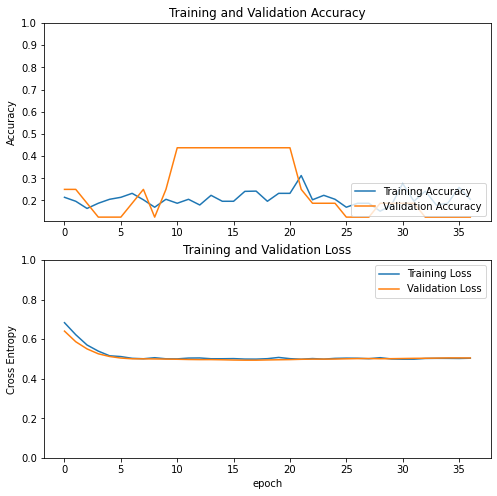

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [88]:
predicts = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

1/1 [==============================] - 0s 4ms/step


In [91]:
predicted_class_indices=np.argmax(predicts,axis=1)

predicted_class_indices

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [117]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

model.fit(train_generator,
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator,
            validation_steps=STEP_SIZE_VALID,
            epochs=100,
            class_weight=class_weights)

Epoch 1/100
8/8 [==============================] - 33s 4s/step - loss: 9.1440 - accuracy: 0.0656 - val_loss: 2.8490 - val_accuracy: 0.1094
Epoch 2/100
8/8 [==============================] - 33s 4s/step - loss: 2.8297 - accuracy: 0.0656 - val_loss: 2.8345 - val_accuracy: 0.0625
Epoch 3/100
8/8 [==============================] - 35s 4s/step - loss: 2.8542 - accuracy: 0.0586 - val_loss: 2.8340 - val_accuracy: 0.0469
Epoch 4/100
8/8 [==============================] - 35s 4s/step - loss: 2.8128 - accuracy: 0.0533 - val_loss: 2.8332 - val_accuracy: 0.0469
Epoch 5/100
8/8 [==============================] - 37s 5s/step - loss: 2.8547 - accuracy: 0.0779 - val_loss: 2.8337 - val_accuracy: 0.0625
Epoch 6/100
8/8 [==============================] - 36s 4s/step - loss: 2.8194 - accuracy: 0.0820 - val_loss: 2.8339 - val_accuracy: 0.0625
Epoch 7/100
8/8 [==============================] - 34s 4s/step - loss: 2.8014 - accuracy: 0.0533 - val_loss: 2.8334 - val_accuracy: 0.0625
Epoch 8/100
8/8 [==========

KeyboardInterrupt: 

In [ ]:
model.evaluate(valid_generator,steps=STEP_SIZE_TEST)

In [52]:
test_generator.reset()
pred=model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

5/5 [==============================] - 5s 984ms/step


In [53]:
predicted_class_indices=np.argmax(pred,axis=1)

In [54]:
predicted_class_indices

array([ 2,  2,  3,  2, 18, 28,  3,  2, 34, 14,  2,  3, 29, 33,  3, 19,  3,
       34,  6, 34, 26,  3,  3, 34,  2, 20, 26, 27, 34,  2, 12, 24,  2, 29,
       26,  3, 26,  3, 33,  2, 35,  1,  3, 26, 20, 14,  2, 33,  3,  2, 19,
       34, 21, 32, 11, 26, 34,  3,  3, 29, 26,  2,  2,  2, 26,  3,  3,  3,
        2, 19, 33,  2, 26, 28, 34, 33,  3,  2,  2,  2, 26,  2, 30,  3,  2,
        2, 33,  2, 21,  3,  2, 26, 35,  2, 34, 26, 14, 26,  3, 19, 35,  2,
       26,  3,  2, 33, 25, 26,  3, 15,  2,  3, 12,  3, 29,  2, 35, 17,  2,
        2,  9, 34,  2,  6,  3, 26,  6, 29, 34, 14, 21,  2,  2,  2, 34,  2,
        2,  2, 35, 33, 24,  3,  2, 34, 26,  2,  2, 28,  3,  2,  2, 33,  6,
       33, 26,  2, 20, 35,  2,  2, 33,  3, 19,  3, 19,  3, 30,  2,  3, 26,
       26, 26,  3,  3, 26, 12, 33,  3,  2,  2, 15,  3, 33,  2,  2])

In [56]:
beer_test

,local,brand
641,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,budweiser
47,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,san miguel
729,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,cruzcampo
300,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,amstel original
677,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,free damm
...,...,...
129,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,desperado
587,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,dia
405,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,cruzcampo
250,/home/ivan/Documentos/IRONHACK/Bootcamp/final_...,cruzcampo reserva


In [20]:
import tensorflow as tf
from PIL import Image

In [41]:
reloaded_model = tf.keras.models.load_model('../saved_model/model_3_inceptionv3_280x280.h5')

NameError: name 'hub' is not defined

In [ ]:
images_to_predict = format_image(folder_path)
predicts = model.predict(images_to_predict)
predicted_class_indices = np.argmax(predicts, axis=1)
labels = {0: 'estrella galicia', 1: 'heineken', 2: 'mahou 5 estrellas'}
predictions = [labels[k] for k in predicted_class_indices]